# **DIP ASSIGNMENT 1**

### Find the following parameters in a document using RLSA

- NUMBER OF COLUMNS (SINGLE VS DOUBLE)
- NUMBER OF LINES OF TEXT IN EACH COLUMN
- NUMBER OF IMAGES IN SCANNED PAGE
- NUMBER OF WORDS IN A LINE
- NUMBER OF LETTERS IN A LINE


In [1]:
import numpy as np
import matplotlib.pyplot as plt

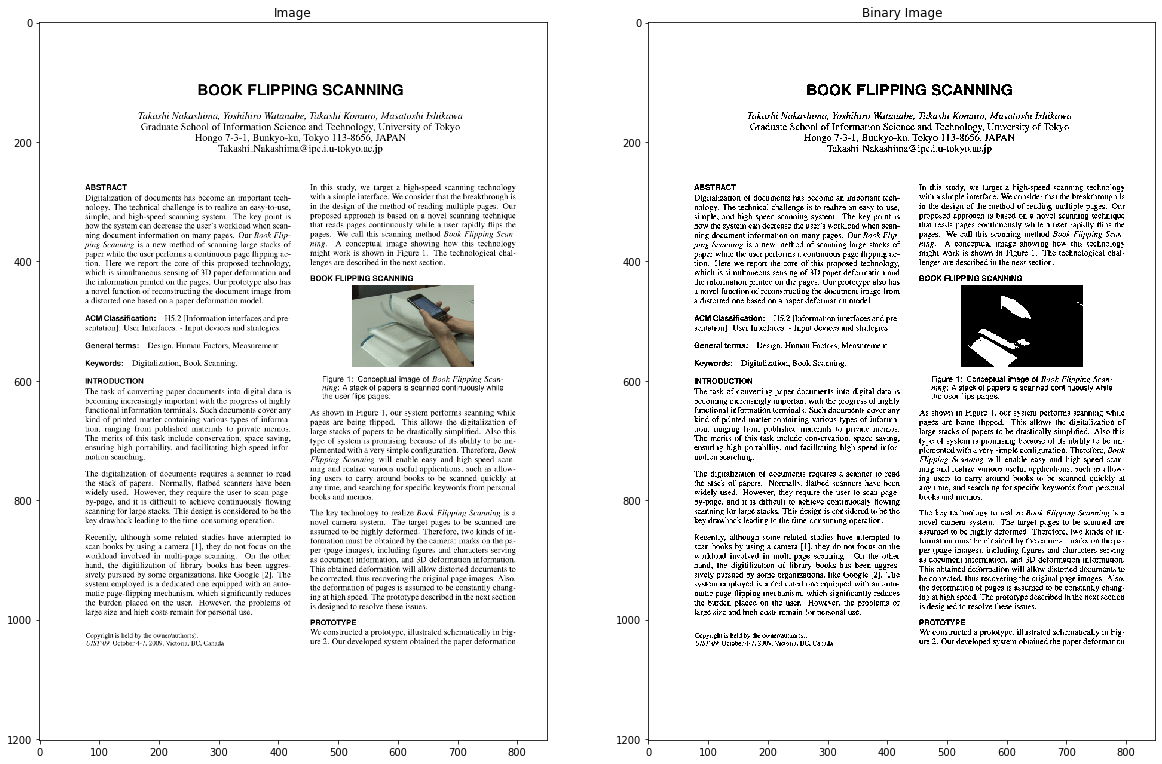

In [63]:
from skimage.color import rgb2gray

path = '/Users/hassaanmuzammil/Desktop/SEM 7/Digital Image Processing/largepreview.png'
img = plt.imread(path)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Image')

img_gray = rgb2gray(img)
img_bin = (img_gray > 0.7).astype('uint16')

plt.subplot(1,2,2)
plt.title('Binary Image')
plt.imshow(img_bin, cmap='gray')

plt.show()

# **THRESHOLD CONVERSION**

In [64]:
def threshold_transform(lst, th):
    """
    Input: 
          Binary List (lst), threshold (th)
    Output: 
          Binary List (new_lst) after threshold transformation
    """
    new_lst = [] 
    count = 0
    for i in range(len(lst)):
        if lst[i] == 0:
            if count > th:
                for j in range(count):
                    new_lst.append(1)
            if count <= th:
                for j in range(count):
                    new_lst.append(0)
            new_lst.append(0)
            count = 0
        else:
            count += 1
    for i in range(count):
        if count > th:
            new_lst.append(1)
        else:
            new_lst.append(0)
    return new_lst

# **HORIZONTAL RLSA**

In [65]:
def rlsa_horizontal(arr, th=8):
    """
    Input: 
          2d numpy array (arr) consisting of 0's and 1's
          threshold (th) for consecutive number of 1's to be converted to 0's
    Output:
          2d array (result) after rlsa horizontal transformation
    """
    result = np.zeros(arr.shape)
    
    for i in range(arr.shape[0]):
        row = threshold_transform(list(arr[i]), th)
        result[i] = np.array(row)
    
    return result

# **VERTICAL RLSA**

In [66]:
def rlsa_vertical(arr, th=8):
    """
    Input: 
          2d numpy array (arr) consisting of 0's and 1's
          threshold (th) for consecutive number of 1's to be converted to 0's
    Output:
          2d array (result) after rlsa vertical transformation
    """
    
    result = np.zeros(arr.shape)
    
    for i in range(arr.shape[1]):
        col = threshold_transform(list(arr[:,i]), th)
        result[:,i] = np.array(col)
    
    return result

In [67]:
result_horizontal = rlsa_horizontal(img_bin,30).astype('uint16')

In [68]:
result_vertical = rlsa_vertical(img_bin, th=20).astype('uint16')

# **COMBINING HORIZONTAL & VERTICAL RLSA**

In [69]:
def rlsa_(img_bin):
    
    result_horizontal = rlsa_horizontal(img_bin,30).astype('uint16')
    result_vertical = rlsa_vertical(img_bin, th=30).astype('uint16')
    
    result = np.logical_or(result_horizontal, result_vertical)
    
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(result_horizontal, cmap='gray')
    plt.title('Horizontal RLSA')
    plt.subplot(1,3,2)
    plt.imshow(result_vertical, cmap='gray')
    plt.title('Vertical RLSA')
    plt.subplot(1,3,3)
    plt.imshow(result, cmap='gray')
    plt.title('Combined RLSA')
    plt.show()
    
    return result

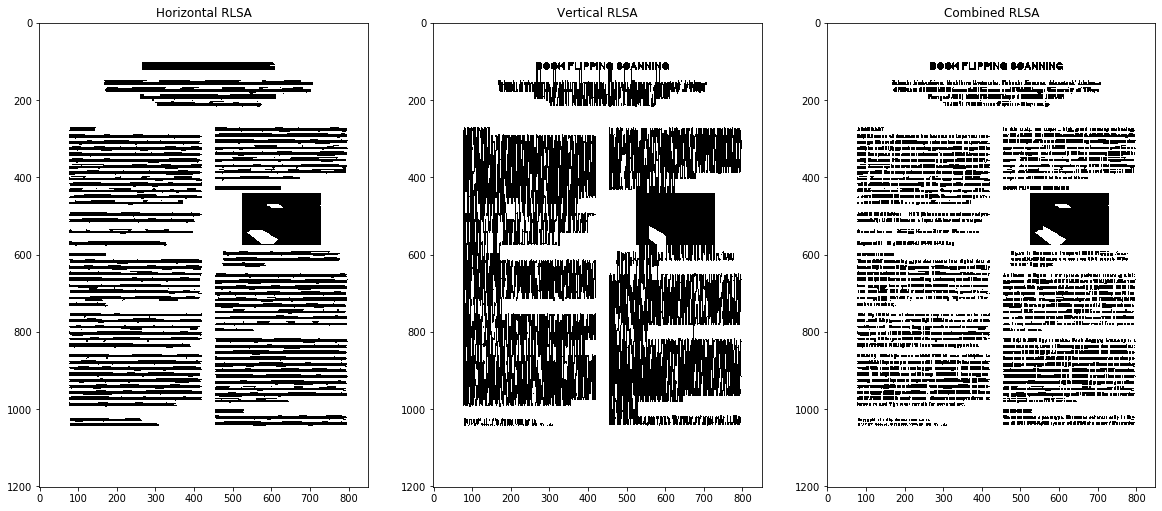

In [70]:
result = rlsa_(img_bin)

# **NUMBER OF PICTURES IN SCANNED DOCUMENT**

No. of images in scanned document:  2
Image 1 found at Rows:  450 - 566 Columns 533 - 717
Image 2 found at Rows:  558 - 566 Columns 533 - 544


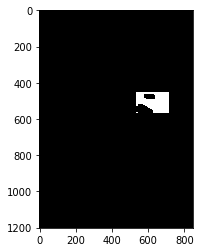

In [71]:
from scipy.ndimage import morphology
import cv2

def count_images(img):
    s = np.ones((20,20))
    d = morphology.binary_dilation(img, s)
    d = np.logical_not(d)
    d = d.astype('uint8')
    plt.imshow(d,cmap='gray')
    
    images, labels = cv2.connectedComponents(d)
    
    print('No. of images in scanned document: ', images-1)
    
    coords = []
    for i in range(1,np.max(labels)+1):
        x1,x2 = (np.where(labels==i)[0][0], np.where(labels==i)[0][-1])
        y1,y2 = (np.where(labels==i)[1][0], np.where(labels==i)[1][-1])
        print('Image',i, 'found at Rows: ',x1,'-',x2, 'Columns', y1,'-',y2)
        coords.append([x1,x2,y1,y2])
    
    return coords

coords = count_images(result)

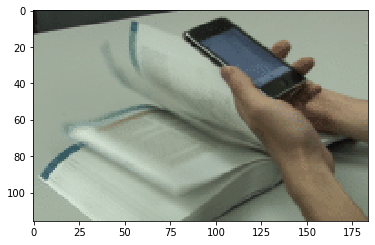

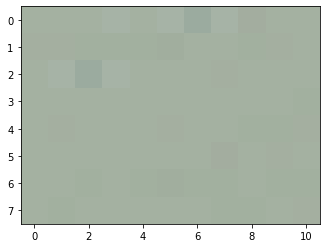

In [72]:
for i in coords:
    plt.imshow(img[i[0]:i[1],i[2]:i[3]])
    plt.show()

# **EXTRACT THE HEADING, SUB-HEADING & TEXT**

In [73]:
def get_row_sections(img_bin):
    
    result_vertical = rlsa_vertical(img_bin, th=20).astype('uint16')
    
    flag = False
    row = 0
    lst_row = []
    for i in range(result_vertical.shape[0]):
        if all(p for p in result_vertical[i] == 1):
            flag = True
        else:
            if flag == True:
                row += 1
                lst_row.append(i)
                flag = False
    row
    lst_row = sorted(lst_row)
    
    print(lst_row)
    print('Main text portion starts at row: ',lst_row[-1])
    
    row_dict = {}
    for i in range(len(lst_row)):
        try:
            row_dict['row'+str(i)] = img_bin[lst_row[i]:lst_row[i+1]]
        except:
            row_dict['row'+str(i)] = img_bin[lst_row[i]:]

    row_dict['row2'].shape
    
    return row_dict

In [74]:
row_dict = get_row_sections(img_bin)
row_dict['row2'].shape

[104, 151, 272]
Main text portion starts at row:  272


(930, 850)

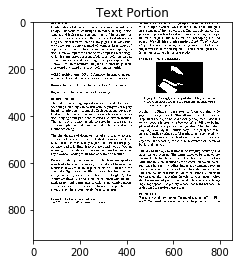

In [75]:
plt.imshow(row_dict['row2'],cmap='gray')
plt.title('Text Portion')
plt.show()

# **EXTRACTING COLUMNS**

In [76]:
def get_column_sections(img_bin):
    """
    Input: 
          2d numpy array of binary image (img_bin)
    Output:
          A dictionary containing column sections (col_dict) {name:2d-array}
    """
    col = 0
    lst_col = [] 
    res = rlsa_horizontal(row_dict['row2'])
    
    for i in range(res.shape[1]):
        if all(p for p in res[:,i] == 1):
            flag = True
        else:
            if flag == True:
                col += 1
                lst_col.append(i)
                flag = False
    print('Number of Columns in document:', col)
    print(lst_col)
    
    txt_img = row_dict['row2']
    col_dict = {}
    for i in range(len(lst_col)):
        try:
            col_dict['col'+str(i)] = txt_img[:,lst_col[i]:lst_col[i+1]]
        except:
            col_dict['col'+str(i)] = txt_img[:,lst_col[i]:]
    
    return col_dict


In [77]:
col_dict = get_column_sections(row_dict['row2'])
col_dict['col0'].shape

Number of Columns in document: 2
[76, 454]


(930, 378)

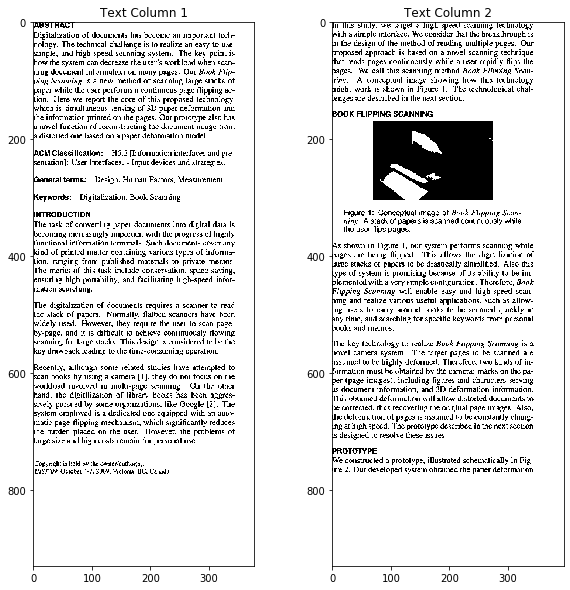

In [78]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(col_dict['col0'],cmap='gray')
plt.title('Text Column 1')

plt.subplot(1,2,2)
plt.imshow(col_dict['col1'],cmap='gray')
plt.title('Text Column 2')
plt.show()

# **EXTRACTING LINES FROM COLUMNS**

In [79]:
def get_lines_from_column(col):
    
    """
    Input: 
          Binary image 2d numpy array (text portion of single column)
    Output:
          Starting Indices of each line
    """
    lines = 0
    lines_col = []
    flag = True
    for i in range(col.shape[0]):
        if all(p == 1 for p in col[i]):
            flag = True
        else:
            if flag == True:
                lines += 1
                lines_col.append(i)
                flag = False
                
    return lines_col

In [80]:
lines_col_0 = get_lines_from_column(col_dict['col0'])

print('Number of lines in column 0: ',len(lines_col_0))
print('Starting indices of each line: ', lines_col_0)

Number of lines in column 0:  43
Starting indices of each line:  [0, 17, 33, 48, 64, 80, 95, 111, 127, 142, 158, 173, 189, 219, 235, 264, 294, 324, 341, 357, 372, 388, 404, 419, 435, 451, 479, 494, 510, 526, 541, 557, 585, 601, 617, 632, 648, 663, 679, 695, 710, 751, 764]


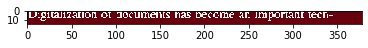

In [81]:
plt.imshow(col_dict['col0'][18:33],cmap='Reds')

No. of images in scanned document:  2
Image 1 found at Rows:  178 - 294 Columns 79 - 263
Image 2 found at Rows:  286 - 294 Columns 79 - 90


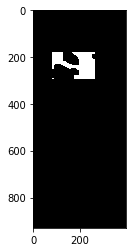

In [82]:
coordinates = count_images(col_dict['col1'])

In [83]:
lines_col_1 = get_lines_from_column(col_dict['col1'])
print('Number of lines in column 1: ',len(lines_col_1))
print('Number of lines of text in column 1: ',len(lines_col_1)-len(coordinates))
print('Starting indices of each line: ', lines_col_1)

Number of lines in column 1:  38
Number of lines of text in column 1:  36
Starting indices of each line:  [0, 15, 31, 47, 62, 78, 94, 109, 125, 152, 169, 320, 335, 349, 377, 392, 408, 424, 439, 455, 471, 486, 502, 518, 544, 560, 576, 591, 607, 623, 638, 654, 670, 685, 701, 728, 744, 760]


In [84]:
def print_line(col, line):
    if col == 0:
        c = col_dict['col0']
        l = lines_col_0
    else:
        c = col_dict['col1']
        l = lines_col_1
        
    i1 = l[line]
    try:
        i2 = l[line+1]
    except:
        i2 = 931
        
    print('Printing Line:',line,'in Column:',col)
    
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(c[i1:i2],cmap='gray')
    plt.show()
    
    return c[i1:i2]

Printing Line: 0 in Column: 0


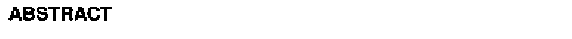

Printing Line: 1 in Column: 0


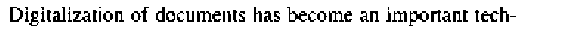

Printing Line: 2 in Column: 0


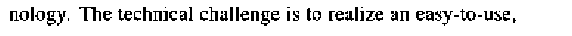

Printing Line: 3 in Column: 0


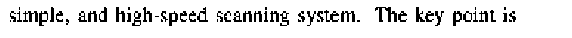

Printing Line: 4 in Column: 0


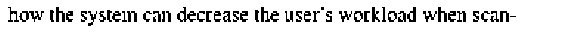

Printing Line: 5 in Column: 0


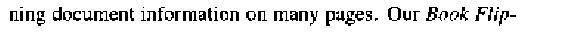

Printing Line: 6 in Column: 0


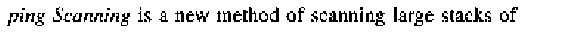

Printing Line: 7 in Column: 0


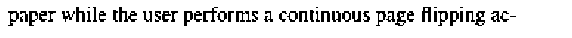

Printing Line: 8 in Column: 0


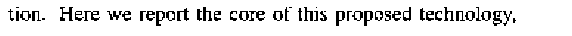

Printing Line: 9 in Column: 0


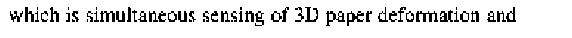

Printing Line: 10 in Column: 0


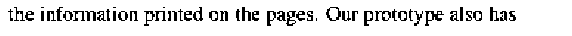

Printing Line: 11 in Column: 0


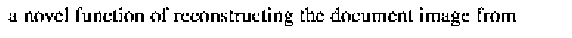

Printing Line: 12 in Column: 0


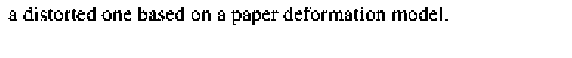

Printing Line: 13 in Column: 0


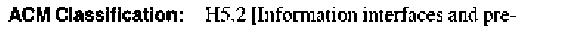

Printing Line: 14 in Column: 0


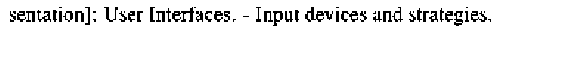

Printing Line: 15 in Column: 0


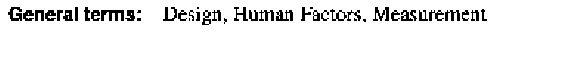

Printing Line: 16 in Column: 0


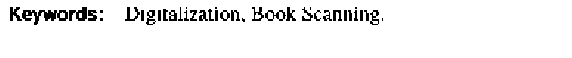

Printing Line: 17 in Column: 0


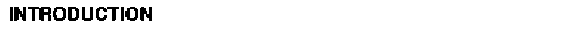

Printing Line: 18 in Column: 0


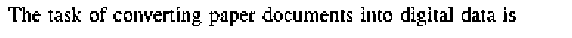

Printing Line: 19 in Column: 0


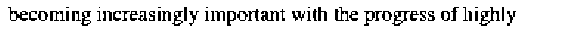

Printing Line: 20 in Column: 0


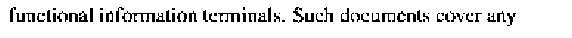

Printing Line: 21 in Column: 0


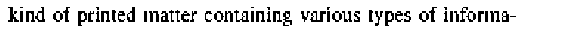

Printing Line: 22 in Column: 0


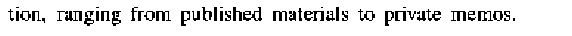

Printing Line: 23 in Column: 0


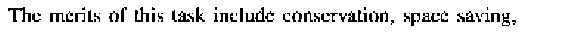

Printing Line: 24 in Column: 0


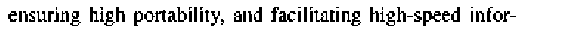

Printing Line: 25 in Column: 0


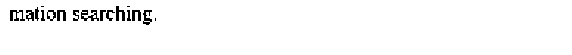

Printing Line: 26 in Column: 0


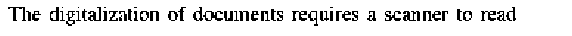

Printing Line: 27 in Column: 0


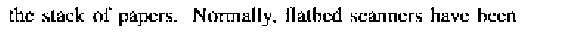

Printing Line: 28 in Column: 0


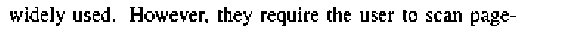

Printing Line: 29 in Column: 0


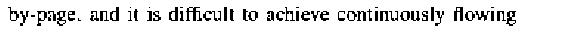

Printing Line: 30 in Column: 0


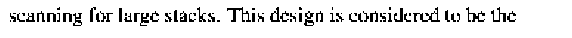

Printing Line: 31 in Column: 0


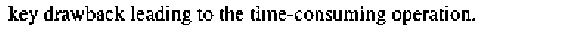

Printing Line: 32 in Column: 0


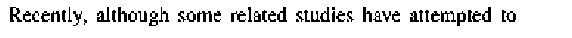

Printing Line: 33 in Column: 0


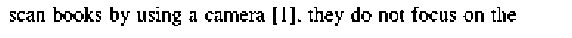

Printing Line: 34 in Column: 0


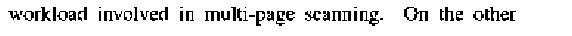

Printing Line: 35 in Column: 0


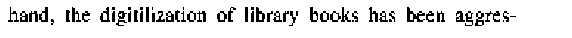

Printing Line: 36 in Column: 0


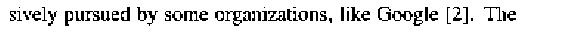

Printing Line: 37 in Column: 0


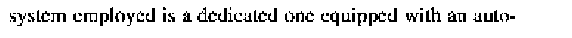

Printing Line: 38 in Column: 0


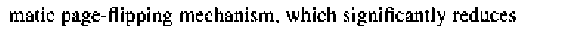

Printing Line: 39 in Column: 0


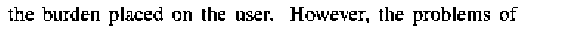

Printing Line: 40 in Column: 0


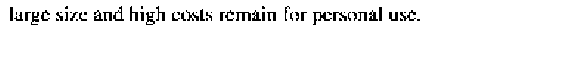

Printing Line: 41 in Column: 0


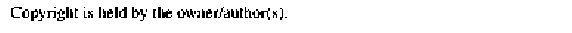

Printing Line: 42 in Column: 0


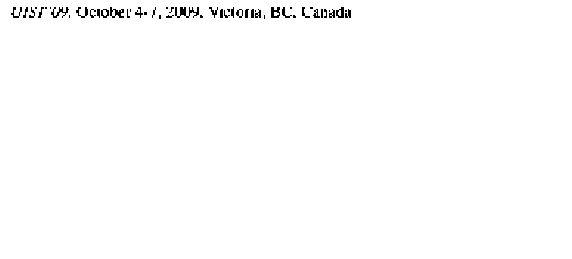

In [85]:
for i in range(0,len(lines_col_0)):
    c = print_line(col=0,line=i)
    pass

# **EXTRACTING WORDS FROM LINE**

In [86]:
def get_words(col, line):
    flag = True
    line2 = rlsa_horizontal(print_line(col,line),th=3)
    words = 0
    for i in range(line2.shape[1]):
        if all(p for p in line2[:,i]==1):
            flag = True
        else:
            if flag == True:
                words += 1
                flag = False
    print('Total number of words: ',words)
    
    return words

Printing Line: 2 in Column: 0


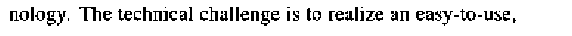

In [87]:
c = print_line(col=0,line=2)

# COLUMN 0

Printing Line: 0 in Column: 0


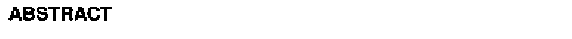

Total number of words:  1


Printing Line: 1 in Column: 0


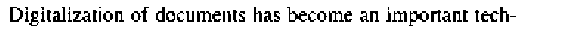

Total number of words:  8


Printing Line: 2 in Column: 0


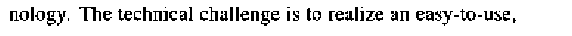

Total number of words:  9


Printing Line: 3 in Column: 0


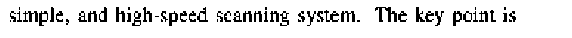

Total number of words:  9


Printing Line: 4 in Column: 0


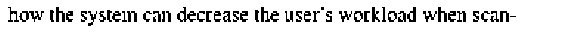

Total number of words:  12


Printing Line: 5 in Column: 0


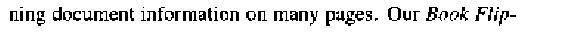

Total number of words:  9


Printing Line: 6 in Column: 0


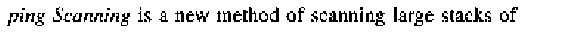

Total number of words:  11


Printing Line: 7 in Column: 0


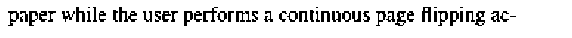

Total number of words:  11


Printing Line: 8 in Column: 0


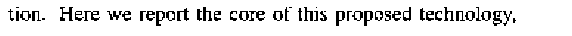

Total number of words:  10


Printing Line: 9 in Column: 0


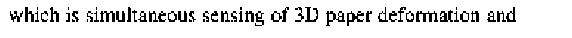

Total number of words:  9


Printing Line: 10 in Column: 0


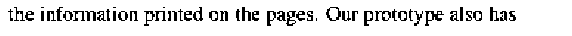

Total number of words:  10


Printing Line: 11 in Column: 0


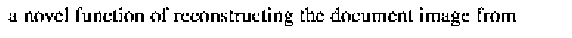

Total number of words:  9


Printing Line: 12 in Column: 0


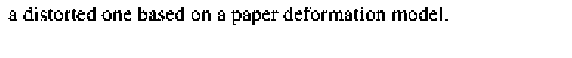

Total number of words:  9


Printing Line: 13 in Column: 0


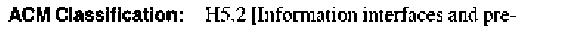

Total number of words:  8


Printing Line: 14 in Column: 0


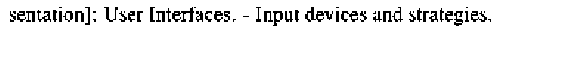

Total number of words:  8


Printing Line: 15 in Column: 0


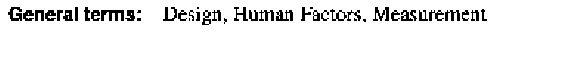

Total number of words:  6


Printing Line: 16 in Column: 0


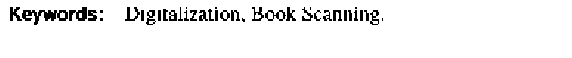

Total number of words:  4


Printing Line: 17 in Column: 0


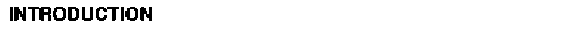

Total number of words:  1


Printing Line: 18 in Column: 0


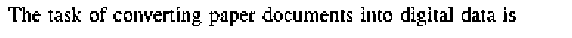

Total number of words:  10


Printing Line: 19 in Column: 0


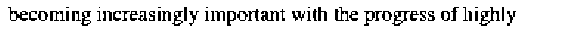

Total number of words:  7


Printing Line: 20 in Column: 0


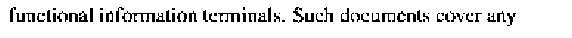

Total number of words:  7


Printing Line: 21 in Column: 0


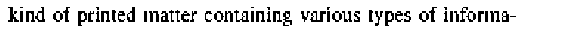

Total number of words:  9


Printing Line: 22 in Column: 0


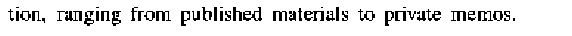

Total number of words:  8


Printing Line: 23 in Column: 0


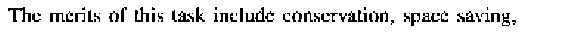

Total number of words:  9


Printing Line: 24 in Column: 0


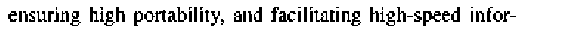

Total number of words:  7


Printing Line: 25 in Column: 0


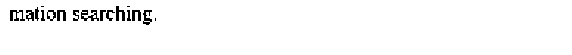

Total number of words:  2


Printing Line: 26 in Column: 0


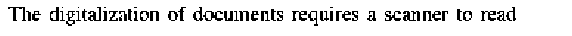

Total number of words:  9


Printing Line: 27 in Column: 0


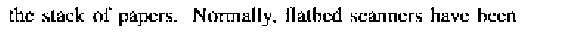

Total number of words:  9


Printing Line: 28 in Column: 0


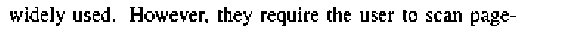

Total number of words:  11


Printing Line: 29 in Column: 0


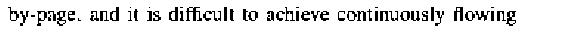

Total number of words:  9


Printing Line: 30 in Column: 0


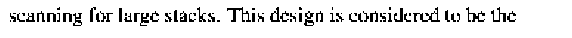

Total number of words:  11


Printing Line: 31 in Column: 0


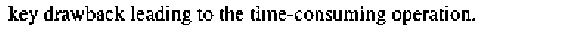

Total number of words:  8


Printing Line: 32 in Column: 0


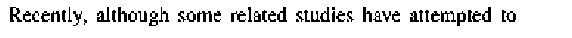

Total number of words:  8


Printing Line: 33 in Column: 0


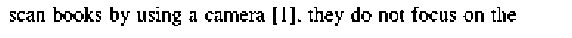

Total number of words:  15


Printing Line: 34 in Column: 0


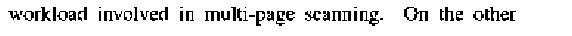

Total number of words:  8


Printing Line: 35 in Column: 0


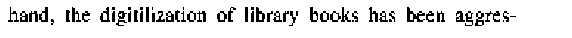

Total number of words:  9


Printing Line: 36 in Column: 0


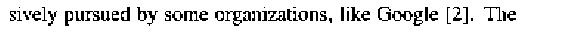

Total number of words:  9


Printing Line: 37 in Column: 0


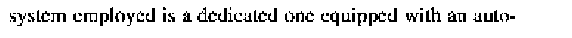

Total number of words:  10


Printing Line: 38 in Column: 0


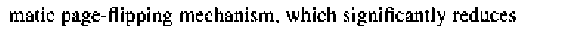

Total number of words:  7


Printing Line: 39 in Column: 0


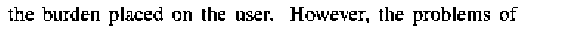

Total number of words:  10


Printing Line: 40 in Column: 0


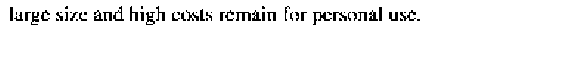

Total number of words:  9


Printing Line: 41 in Column: 0


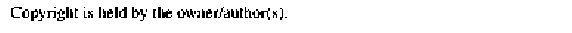

Total number of words:  5


Printing Line: 42 in Column: 0


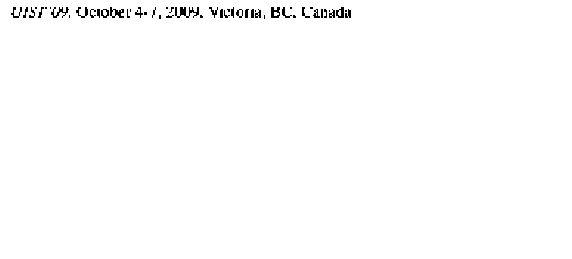

Total number of words:  9




In [88]:
for i in range(len(lines_col_0)):
    words = get_words(col=0,line=i)
    print('\n')

# COLUMN 1

Printing Line: 0 in Column: 1


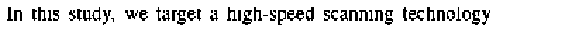

Total number of words:  9


Printing Line: 1 in Column: 1


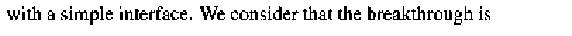

Total number of words:  10


Printing Line: 2 in Column: 1


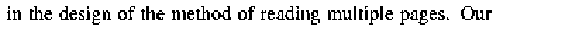

Total number of words:  11


Printing Line: 3 in Column: 1


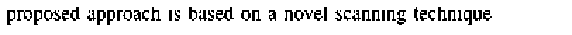

Total number of words:  9


Printing Line: 4 in Column: 1


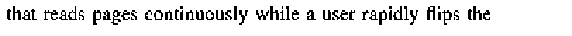

Total number of words:  10


Printing Line: 5 in Column: 1


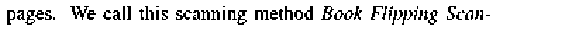

Total number of words:  9


Printing Line: 6 in Column: 1


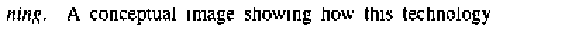

Total number of words:  8


Printing Line: 7 in Column: 1


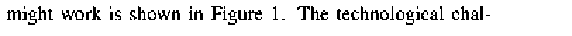

Total number of words:  10


Printing Line: 8 in Column: 1


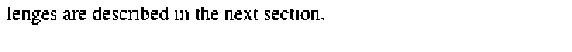

Total number of words:  7


Printing Line: 9 in Column: 1


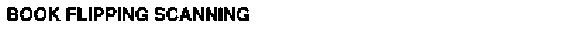

Total number of words:  3


Printing Line: 10 in Column: 1


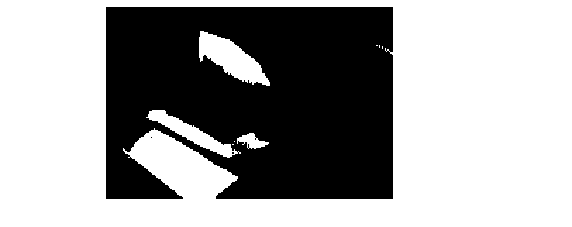

Total number of words:  1


Printing Line: 11 in Column: 1


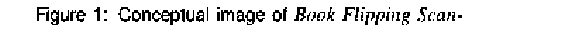

Total number of words:  8


Printing Line: 12 in Column: 1


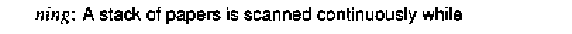

Total number of words:  9


Printing Line: 13 in Column: 1


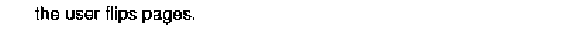

Total number of words:  4


Printing Line: 14 in Column: 1


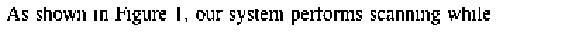

Total number of words:  10


Printing Line: 15 in Column: 1


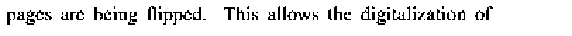

Total number of words:  9


Printing Line: 16 in Column: 1


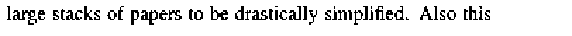

Total number of words:  10


Printing Line: 17 in Column: 1


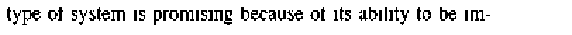

Total number of words:  12


Printing Line: 18 in Column: 1


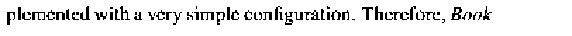

Total number of words:  8


Printing Line: 19 in Column: 1


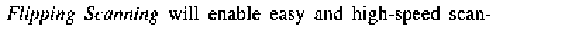

Total number of words:  8


Printing Line: 20 in Column: 1


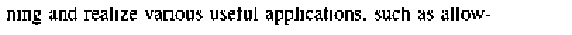

Total number of words:  9


Printing Line: 21 in Column: 1


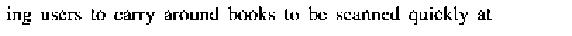

Total number of words:  11


Printing Line: 22 in Column: 1


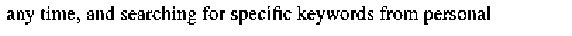

Total number of words:  9


Printing Line: 23 in Column: 1


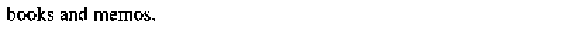

Total number of words:  3


Printing Line: 24 in Column: 1


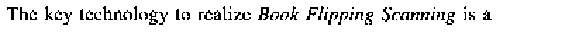

Total number of words:  10


Printing Line: 25 in Column: 1


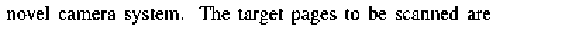

Total number of words:  10


Printing Line: 26 in Column: 1


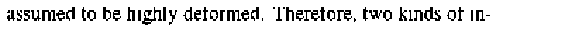

Total number of words:  10


Printing Line: 27 in Column: 1


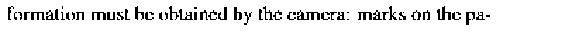

Total number of words:  11


Printing Line: 28 in Column: 1


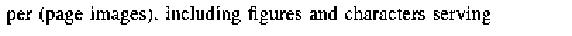

Total number of words:  8


Printing Line: 29 in Column: 1


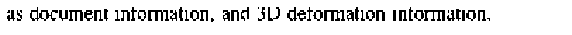

Total number of words:  7


Printing Line: 30 in Column: 1


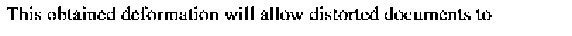

Total number of words:  8


Printing Line: 31 in Column: 1


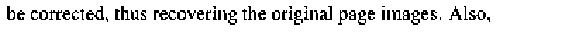

Total number of words:  9


Printing Line: 32 in Column: 1


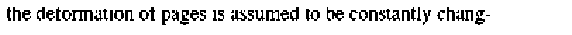

Total number of words:  10


Printing Line: 33 in Column: 1


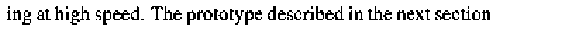

Total number of words:  10


Printing Line: 34 in Column: 1


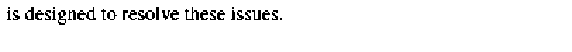

Total number of words:  6


Printing Line: 35 in Column: 1


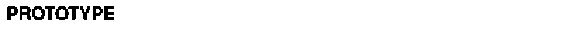

Total number of words:  1


Printing Line: 36 in Column: 1


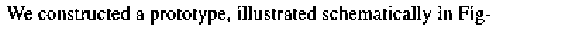

Total number of words:  8


Printing Line: 37 in Column: 1


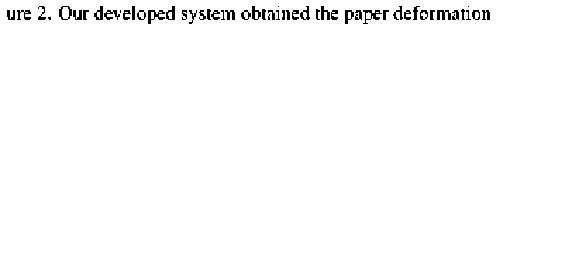

Total number of words:  9




In [89]:
for i in range(len(lines_col_1)):
    get_words(col=1,line=i)  
    print('\n')

# **EXTRACTING LETTERS FROM LINE**

In [90]:
def get_letters(col, line):
    flag = True
    line2 = print_line(col,line)
    line2 = rlsa_vertical(line2,th=5) #rlsa vertical
    line2 = np.logical_not(line2).astype('uint8') #black to white and viceversa

    letters, _ = cv2.connectedComponents(line2) #get the separate letters
    letters = letters - 1 #subtract the background black label
    
    print('Total number of letters: ',letters)
    return letters

Printing Line: 0 in Column: 1


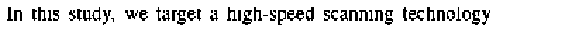

Total number of letters:  46


Printing Line: 1 in Column: 1


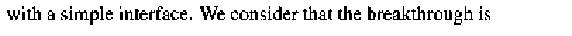

Total number of letters:  41


Printing Line: 2 in Column: 1


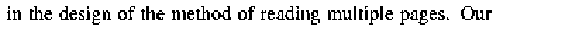

Total number of letters:  46


Printing Line: 3 in Column: 1


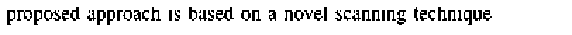

Total number of letters:  44


Printing Line: 4 in Column: 1


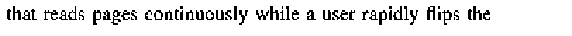

Total number of letters:  47


Printing Line: 5 in Column: 1


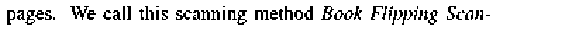

Total number of letters:  48


Printing Line: 6 in Column: 1


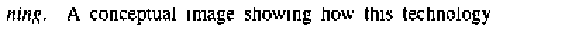

Total number of letters:  42


Printing Line: 7 in Column: 1


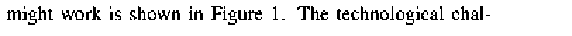

Total number of letters:  44


Printing Line: 8 in Column: 1


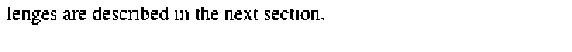

Total number of letters:  33


Printing Line: 9 in Column: 1


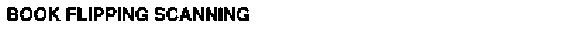

Total number of letters:  20


Printing Line: 10 in Column: 1


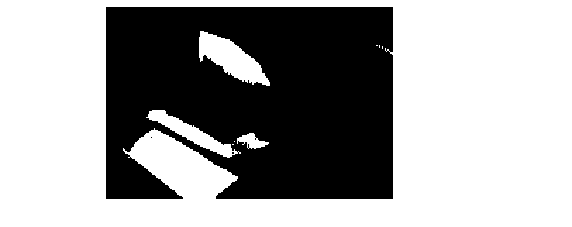

Total number of letters:  1


Printing Line: 11 in Column: 1


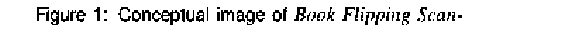

Total number of letters:  44


Printing Line: 12 in Column: 1


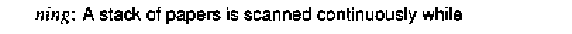

Total number of letters:  40


Printing Line: 13 in Column: 1


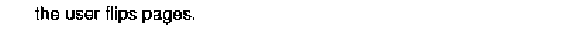

Total number of letters:  17


Printing Line: 14 in Column: 1


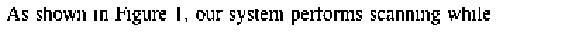

Total number of letters:  44


Printing Line: 15 in Column: 1


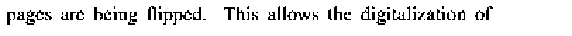

Total number of letters:  46


Printing Line: 16 in Column: 1


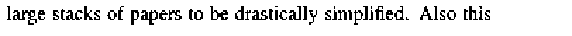

Total number of letters:  44


Printing Line: 17 in Column: 1


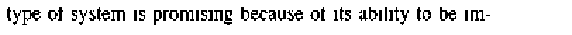

Total number of letters:  42


Printing Line: 18 in Column: 1


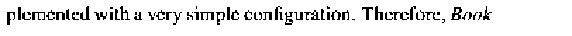

Total number of letters:  51


Printing Line: 19 in Column: 1


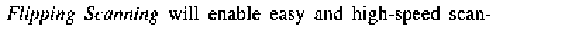

Total number of letters:  49


Printing Line: 20 in Column: 1


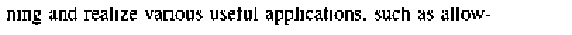

Total number of letters:  47


Printing Line: 21 in Column: 1


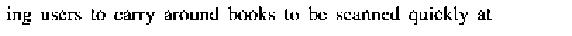

Total number of letters:  42


Printing Line: 22 in Column: 1


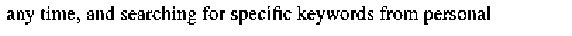

Total number of letters:  46


Printing Line: 23 in Column: 1


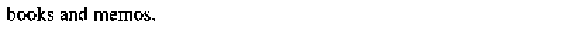

Total number of letters:  11


Printing Line: 24 in Column: 1


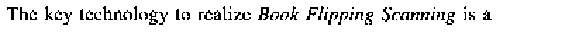

Total number of letters:  50


Printing Line: 25 in Column: 1


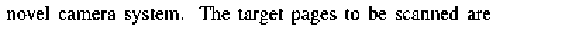

Total number of letters:  42


Printing Line: 26 in Column: 1


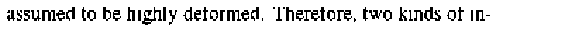

Total number of letters:  42


Printing Line: 27 in Column: 1


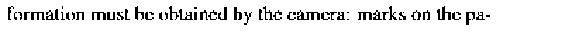

Total number of letters:  44


Printing Line: 28 in Column: 1


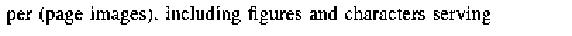

Total number of letters:  46


Printing Line: 29 in Column: 1


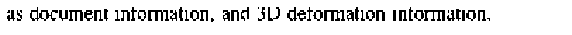

Total number of letters:  41


Printing Line: 30 in Column: 1


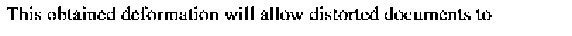

Total number of letters:  48


Printing Line: 31 in Column: 1


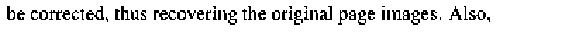

Total number of letters:  50


Printing Line: 32 in Column: 1


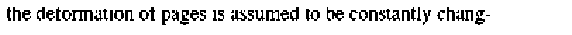

Total number of letters:  41


Printing Line: 33 in Column: 1


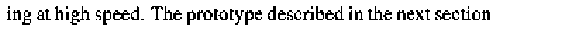

Total number of letters:  42


Printing Line: 34 in Column: 1


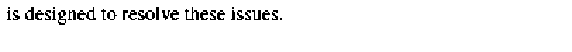

Total number of letters:  27


Printing Line: 35 in Column: 1


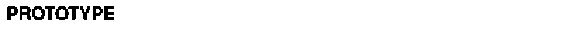

Total number of letters:  6


Printing Line: 36 in Column: 1


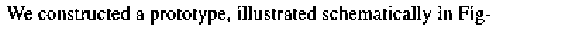

Total number of letters:  49


Printing Line: 37 in Column: 1


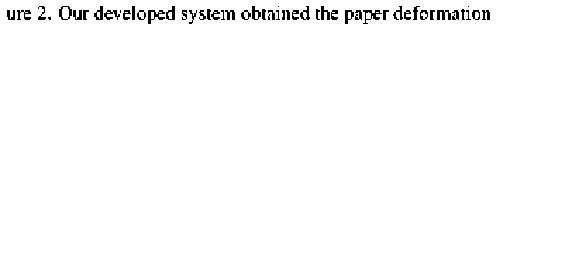

Total number of letters:  47




In [91]:
for i in range(len(lines_col_1)):
    get_letters(col=1,line=i)  
    print('\n')

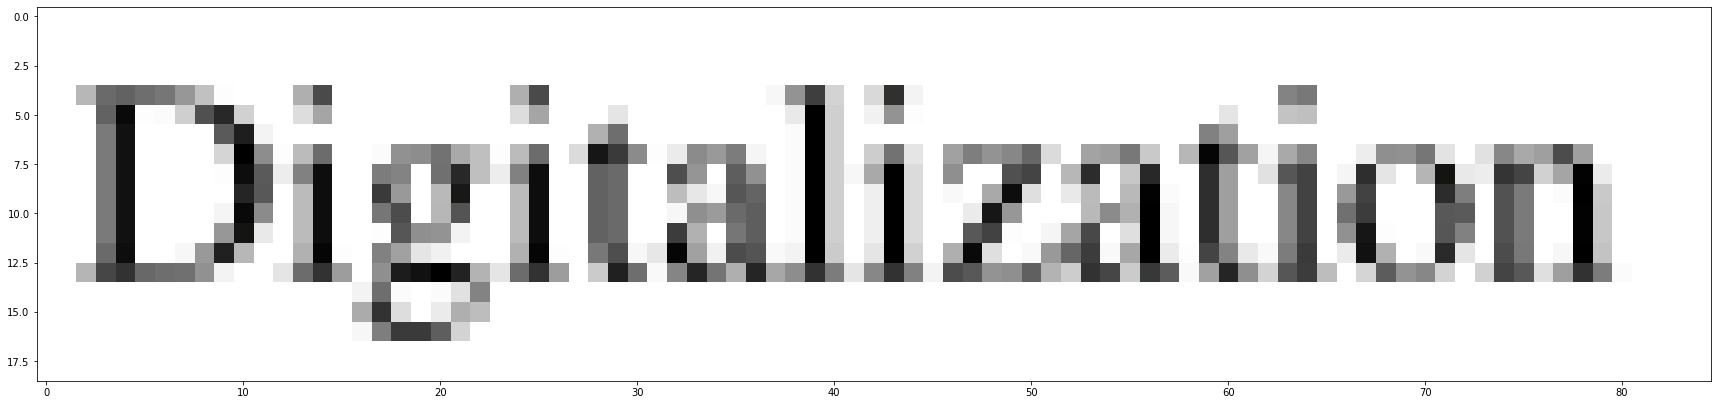

In [92]:
plt.figure(figsize=(30,30))
im = img[285:304,75:160]
plt.imshow(im)
plt.show()

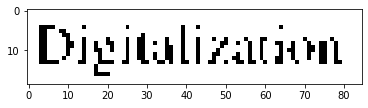

In [93]:
imb = (rgb2gray(im) > 0.5).astype('uint8')
rv = rlsa_vertical(imb,th=1)
plt.imshow(rv,cmap='gray')

In [58]:
from PIL import Image
from pylab import *
im = img_bin[]
plt.figure(figsize=(30,30))
imshow(im)

SyntaxError: invalid syntax (<ipython-input-58-fe21d9da532c>, line 3)